In [1]:
## Import necessary libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential

from sklearn.model_selection import train_test_split
import sklearn
from sklearn import metrics

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random

In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Get the required functions
from helper_functions import unzip_data, create_tensorboard_callback, walk_through_dir, plot_loss_curves, compare_historys

--2024-01-25 17:49:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-25 17:49:11 (99.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Download the text dataset

In [3]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip the data
unzip_data("nlp_getting_started.zip")

--2024-01-25 17:49:11--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2024-01-25 17:49:11 (109 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



# Visualize the text dataset

In [4]:
# Turn csv files into dataframes
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training dataset
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
# checkout test data
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# How many example of each class
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [9]:
# visualize random training examples
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
  _, text, target,  = row
  print(f"Target :{target}", "(real disaster)" if target >0 else" (not real disaster)")
  print(f"Text: \n {text}\n")
  print("----")


Target :0  (not real disaster)
Text: 
 Why Charlie Lim start at 9pm on this Sunday..... I have curfew leh :-(

----
Target :1 (real disaster)
Text: 
 #360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/9Naw3QOQOL

----
Target :0  (not real disaster)
Text: 
 Brunette beauty Night A stretches out on a victorian sofa http://t.co/qew4c5M1xd View and download video

----
Target :0  (not real disaster)
Text: 
 Wrecked emotions.

----
Target :0  (not real disaster)
Text: 
 #landslide while on a trip in #skardu https://t.co/nqNWkTRhsA

----


# Split the data into train-test

In [10]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                         train_df_shuffled["target"].to_numpy(),
                                                                         test_size = 0.1,
                                                                         random_state = 42)

In [11]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [12]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

# Text to Numbers Conversion

## Text Vectorization (Tokenization)

In [13]:
from tensorflow.keras.layers import TextVectorization

In [14]:
# Initialize the text vectorizer
text_vectorizer = TextVectorization(max_tokens= None,
                                    standardize = "lower_and_strip_punctuation",
                                    split = "whitespace",
                                    ngrams = None, # create group of words
                                    output_mode = "int",
                                    output_sequence_length = None,
                                    #pad_to_max_tokens = True
                                    )

In [15]:
# Find average number of tokens (word) in the training tweets
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [16]:
# Set up text vectorization variables
max_vocab_length = 10000 # max number of words in vocab
max_length = 15 # how many words from tweet we will reading

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = "int",
                                    output_sequence_length = max_length
                                    )

In [17]:
# Fit the text vectorizer to training set
text_vectorizer.adapt(data = train_sentences, )

In [18]:
# Create a sample sentence and tokenize it
sample_sentence = "There is a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [19]:
# Choose random sentence from training data
random_sentence = random.choice(train_sentences)
print(f"Original Text : \n {random_sentence}\
       \n\nVectorized version :\n\
       {text_vectorizer(random_sentence)}")

Original Text : 
 'Invading Iraq was a catastrophic mistake'.

Diplomacy needs to replace constant threat of war by US and Israel:

http://t.co/yqjpn3qUUX       

Vectorized version :
       [   1 1831   23    3  586 3621 5808  840    5 1777 5931 1170    6  122
   18]


In [20]:
# get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


# Creating an Embedding using Embedding Layer


In [21]:
from tensorflow.keras.layers import Embedding

In [22]:
embedding = Embedding(input_dim = max_vocab_length,
                      input_length = max_length,
                      output_dim = 128
                      )

embedding

In [23]:
# Get another random sentence
random_sentence = random.choice(train_sentences)
print(f"Original Sentence :\n{random_sentence},\
      \n\nEmbedded Sentence :\n")

sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original Sentence :
@OfficialMqm you are terrorist,      

Embedded Sentence :



<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04179597, -0.04084036,  0.03830922, ...,  0.0069022 ,
          0.04599318,  0.0058602 ],
        [-0.03190005, -0.02800186, -0.01130328, ..., -0.0373555 ,
         -0.04877812, -0.01297507],
        [-0.0208773 ,  0.0420343 ,  0.04060879, ...,  0.03311357,
          0.02651188,  0.01261612],
        ...,
        [-0.01749181,  0.00705657,  0.03327427, ...,  0.00629001,
         -0.0383709 ,  0.02706556],
        [-0.01749181,  0.00705657,  0.03327427, ...,  0.00629001,
         -0.0383709 ,  0.02706556],
        [-0.01749181,  0.00705657,  0.03327427, ...,  0.00629001,
         -0.0383709 ,  0.02706556]]], dtype=float32)>

In [24]:
# Check out sigle tokens embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.04179597, -0.04084036,  0.03830922, -0.03217145,  0.03762159,
         0.01169922,  0.00691934, -0.02454686, -0.01001775, -0.03469502,
         0.01977006,  0.00459492, -0.00299291,  0.0174739 ,  0.01954195,
        -0.00246228,  0.04660263,  0.01067445,  0.0124048 , -0.02129509,
        -0.04363132, -0.04605701, -0.04902738, -0.016563  , -0.03003269,
        -0.04814376,  0.04236481,  0.00632643,  0.00729467, -0.01055654,
         0.04004503, -0.04733781, -0.02603295,  0.03670691,  0.01441516,
        -0.01365083, -0.03792547, -0.04344916,  0.01104546, -0.02961643,
        -0.02640506, -0.0208783 , -0.00947747, -0.0287951 , -0.0065518 ,
        -0.02455121, -0.00896607,  0.02614122,  0.00824423, -0.0482449 ,
        -0.04816364, -0.00053965, -0.02775412, -0.0493465 , -0.01556116,
        -0.01727762,  0.03888878,  0.02699766, -0.01800565, -0.03621493,
         0.00562106, -0.04228812, -0.04370788,  0.0424296 ,  0.01011832,
  

# Modelling on Text Dataset

## Model 0

In [25]:
## Model 0 : Getting a baseline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [26]:
# Create  tokenization and modelling pipeline
model0 = Pipeline([
      ("tfidf", TfidfVectorizer()), # Convert words to number using tf-idf
      ("clf", MultinomialNB())
])

# Fit the pipeline to training data
model0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Evaluate the model
baseline_score = model0.score(val_sentences, val_labels)
print(f"Baseline model achieves accuracy of : {baseline_score * 100:.2f}%")

Baseline model achieves accuracy of : 79.27%


In [28]:
val_labels[:20]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [29]:
# Make predictions
baseline_preds = model0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [30]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [31]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 1: A simple dense model

In [32]:
# Create a tensorboard callback (new callback for each new model)
from helper_functions import create_tensorboard_callback

# create a directory to save tensorboard logs
SAVE_DIR = "model_logs"

In [33]:
# Build model with Functional API
inputs = layers.Input(shape = (1,), dtype = tf.string) # inputs are 1D strings
x = text_vectorizer(inputs) # Turn the input text to number
x = embedding(x) # Turn the numbers to embeddings
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = keras.Model(inputs, outputs, name ="model_1_dense")

In [34]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

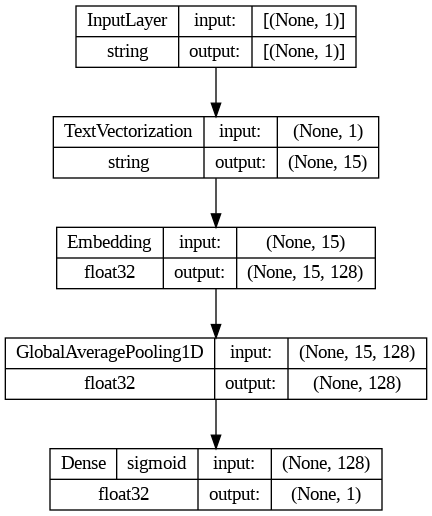

In [35]:
# plot the model
from tensorflow.keras.utils import plot_model

# Pass the model to function for plotting
plot_model(model_1, show_shapes=True, show_dtype=True, show_layer_names=False, show_layer_activations=True)

In [36]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20240125-174913
Epoch 1/5
215/215 [==============================] - 4s 15ms/step - loss: 0.6099 - accuracy: 0.6935 - val_loss: 0.5328 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4418 - accuracy: 0.8187 - val_loss: 0.4672 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3466 - accuracy: 0.8602 - val_loss: 0.4592 - val_accuracy: 0.7940
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2839 - accuracy: 0.8902 - val_loss: 0.4652 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2373 - accuracy: 0.9121 - val_loss: 0.4775 - val_accuracy: 0.7861


In [37]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 5ms/step - loss: 0.4775 - accuracy: 0.7861


[0.4775118827819824, 0.7860892415046692]

In [38]:
# Make some predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 3ms/step


(762, 1)

In [39]:
# Convert model prediction probs to label format
model_1_pred = tf.squeeze(tf.round(model_1_pred_probs))
model_1_pred[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [40]:
# Calculate model 1 results
model_1_results = calculate_results(val_labels, model_1_pred)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7907394181632303,
 'recall': 0.7860892388451444,
 'f1': 0.7831536805930754}

In [41]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard
#%tensorboard --logdir model_logs
#!kill 85358

In [42]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

# Visualize the embeddings

In [43]:
# Check the embedding weights
embedding.weights

[<tf.Variable 'embedding/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-0.03451584,  0.02057246,  0.04746078, ..., -0.00720867,
         -0.02393412,  0.0143014 ],
        [-0.0447382 , -0.03632998,  0.04319089, ...,  0.00561865,
          0.05209928,  0.0008972 ],
        [-0.03290965,  0.01769193,  0.02377263, ..., -0.05066233,
          0.01417785, -0.00717654],
        ...,
        [-0.02618125, -0.0121878 , -0.0210994 , ...,  0.03273553,
          0.01374665, -0.00748111],
        [-0.04445579,  0.05487883,  0.03085705, ..., -0.06941532,
          0.02233535,  0.01051105],
        [-0.10966827,  0.04960085,  0.04007015, ..., -0.04513127,
          0.04509528, -0.03353034]], dtype=float32)>]

In [44]:
len(words_in_vocab ), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [45]:
# Get the weight matrix of embedding layer
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights

array([[-0.03451584,  0.02057246,  0.04746078, ..., -0.00720867,
        -0.02393412,  0.0143014 ],
       [-0.0447382 , -0.03632998,  0.04319089, ...,  0.00561865,
         0.05209928,  0.0008972 ],
       [-0.03290965,  0.01769193,  0.02377263, ..., -0.05066233,
         0.01417785, -0.00717654],
       ...,
       [-0.02618125, -0.0121878 , -0.0210994 , ...,  0.03273553,
         0.01374665, -0.00748111],
       [-0.04445579,  0.05487883,  0.03085705, ..., -0.06941532,
         0.02233535,  0.01051105],
       [-0.10966827,  0.04960085,  0.04007015, ..., -0.04513127,
         0.04509528, -0.03353034]], dtype=float32)

In [46]:
embed_weights.shape

(10000, 128)

In [47]:
# import io

# # Create output writers
# out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
# out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# # Write embedding vectors and words to file
# for num, word in enumerate(words_in_vocab):
#   if num == 0:
#      continue # skip padding token
#   vec = embed_weights[num]
#   out_m.write(word + "\n") # write words to file
#   out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
# out_v.close()
# out_m.close()

# # Download files locally to upload to Embedding Projector
# try:
#   from google.colab import files
# except ImportError:s
#   pass
# else:
#   files.download("embedding_vectors.tsv")
#   files.download("embedding_metadata.tsv")

# Recurrent Neural Networks (RNN's)



## Model 2: LSTM (Long Short Term Memory)

In [48]:
# Create an LSTM Model
inputs = layers.Input(shape = (1,), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
#x = layers.LSTM(64, return_sequences = True)(x)
#print(x.shape)
x = layers.LSTM(64)(x)
#print(x.shape)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Make the model
model_2 = keras.Model(inputs, outputs, name = "model_2_LSTM")


In [49]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                      

In [50]:
# Compile the model
model_2.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])



In [51]:
# Fit the model
history_2 = model_2.fit(train_sentences,
                        train_labels,
                        epochs = 5,
                        validation_data = (val_sentences, val_labels),
                        callbacks = [create_tensorboard_callback(SAVE_DIR, "model_2_lstm")])

Saving TensorBoard log files to: model_logs/model_2_lstm/20240125-174937
Epoch 1/5
215/215 [==============================] - 13s 38ms/step - loss: 0.2185 - accuracy: 0.9221 - val_loss: 0.5830 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 7s 32ms/step - loss: 0.1518 - accuracy: 0.9418 - val_loss: 0.5758 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 6s 30ms/step - loss: 0.1247 - accuracy: 0.9510 - val_loss: 0.7350 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 6s 28ms/step - loss: 0.1013 - accuracy: 0.9584 - val_loss: 1.0916 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0785 - accuracy: 0.9682 - val_loss: 1.0672 - val_accuracy: 0.7717


In [52]:
# Make predictions with lstm
model_2_prob_preds = model_2.predict(val_sentences)
model_2_prob_preds[:10]

24/24 [==============================] - 1s 5ms/step


array([[3.7121594e-02],
       [7.3558247e-01],
       [9.9998975e-01],
       [5.1427986e-03],
       [1.0305121e-04],
       [9.9993044e-01],
       [9.8580402e-01],
       [9.9999613e-01],
       [9.9998802e-01],
       [6.8324500e-01]], dtype=float32)

In [53]:
# convert the preds to labels
model_2_preds = tf.squeeze(tf.round(model_2_prob_preds))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [54]:
# Calculate model 2 results
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 77.16535433070865,
 'precision': 0.7726063176824562,
 'recall': 0.7716535433070866,
 'f1': 0.7699532001851459}

In [55]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 3 : GRU

In [67]:
# Create a GRU network
inputs = layers.Input(shape = (1,), dtype ="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid", name="GRU_output")(x)

# model
model_3 = keras.Model(inputs, outputs)

In [68]:
# Model summary
model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru_1 (GRU)                 (None, 15, 64)            37248     
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                           

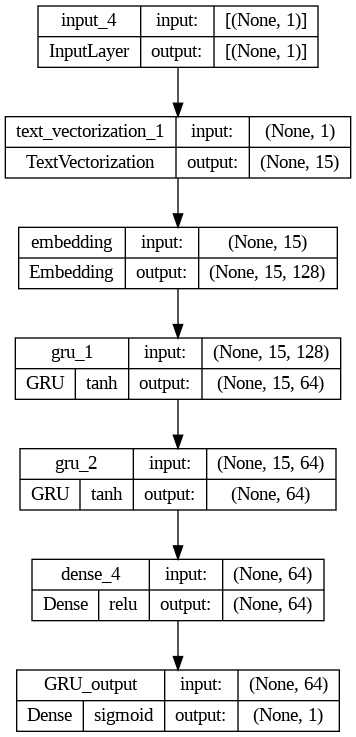

In [69]:
plot_model(model_3, show_shapes=True, show_layer_activations=True)

In [70]:
# Copmpile model
model_3.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy']
                )

# Fit the model
history_3 = model_3.fit(train_sentences,
                        train_labels,
                        validation_data = (val_sentences, val_labels),
                        epochs =5,
                        callbacks = [create_tensorboard_callback(SAVE_DIR, "gru")]
                        )

Saving TensorBoard log files to: model_logs/gru/20240125-180424
Epoch 1/5
215/215 [==============================] - 9s 24ms/step - loss: 0.1179 - accuracy: 0.9590 - val_loss: 1.0400 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0563 - accuracy: 0.9753 - val_loss: 1.3906 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 5s 21ms/step - loss: 0.0461 - accuracy: 0.9777 - val_loss: 1.4771 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 5s 21ms/step - loss: 0.0527 - accuracy: 0.9747 - val_loss: 0.9239 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0489 - accuracy: 0.9777 - val_loss: 1.3457 - val_accuracy: 0.7520


In [71]:
# Evaluate model
model_3.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 9ms/step - loss: 1.3457 - accuracy: 0.7520


[1.3457176685333252, 0.751968502998352]

In [72]:
# Model 3 predictions probs
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[7.6203251e-01],
       [7.6730943e-01],
       [9.9993891e-01],
       [3.6442909e-01],
       [1.1733429e-05],
       [9.9990338e-01],
       [9.4485068e-01],
       [9.9996918e-01],
       [9.9995786e-01],
       [9.9033743e-01]], dtype=float32)

In [73]:
# convert the preds to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [74]:
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 75.19685039370079,
 'precision': 0.7518135850785308,
 'recall': 0.7519685039370079,
 'f1': 0.7518793495086169}